In [1]:
###########################
#return probability with heat map for different behaviour
#with each state and case, with random positions
###########################

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random

import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [3]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(32, 6))

In [4]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case 
    #circuit.barrier(range(n_max)) 
    if n == 0:
        return circuit
    n -= 1    

    if n  >=  tmp:   
        errori(circuit, position, n) 
        if n == tmp: 
            circuit.id(position)    
    #circuit.barrier(range(n_max))
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [5]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [6]:
def errori(circuit, position, n):
    epsilon = 0.5                                #probability p of x error, 1-p prob. of z error                         
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):  
        #circuit.barrier(range(n))
        circuit.x(position)   
        #circuit.barrier(range(n))
    else:
        #circuit.barrier(range(n))
        circuit.z(position)
        #circuit.barrier(range(n))
    return circuit

In [7]:
def qft(circuit, n, n_max, case, position):
    #if case >= 1:
    #    errori(circuit, position, n) 
    #    if case == 1:
    #        circuit.id(position)

    qft_rotations(circuit, n, n_max, case, position)

    if case >= n + 1:
        errori(circuit, position, n)
        if case == n + 1:
            circuit.id(position)
        
    #circuit.barrier(range(n))
    swap_registers(circuit, n)    

    if case >= n + 2:
        errori(circuit, position , n)
        if case == n + 2:
            circuit.id(position)
        
        
    if case >= 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [8]:
def split_circuit_by_id(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('id'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [13]:
n = 3

#Each line contains the results of the aplitude for each state of the complete basis
somma =  [0]*(2**n)
reps = 30
x = []
matrix = np.empty([n + 2,2**n])
#change case (0, n + 2) and position (0,n - 1), case = 0 means no errors
for line in range(n + 2):
    for ripetizioni in range(reps):
        case = line
        amplitudes =  [0]*(2**n) 

        #for case in range(3):
        #case = 4
        position = random.randint(0, n - 1)
        #print(position)
        #for position in range(n):

        control = QuantumRegister(n, 'r1')
        circuit = QuantumCircuit(control)

        qft(circuit, n, n, case, position)  

        #creo il circuito di QFT totale
        #circuit.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

        #taglio il circuito in corrispondenza dell'ultimo gate di errore
        for subcircuit in (split_circuit_by_id(circuit)):
            circuit_left = subcircuit
        #circuit_left.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

        #creo una lista di elementi di eliminare, ovvero gli indici di dove sono i flip
        remove = []
        circuit_right = QuantumCircuit(control)
        #for subcircuit in (split_circuit_by_id(circuit)):
        #    circuit_right = subcircuit
        circuit_right.data = circuit_left.data

        circuit_right.data = list(circuit_right.data)
        for i in range(len(circuit_right.data)):
            if circuit_right.data[i].operation.name == 'x' or circuit_right.data[i].operation.name == 'z':
                remove.append(i)

        #creo il circuito speculare privo di errori
        for elem in sorted(remove, reverse = True):
            del circuit_right.data[elem]
        #circuit_right.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

        circuit_right = circuit_right.inverse()
        merge = circuit_left.compose(circuit_right)

        #merge.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

        backend = Aer.get_backend('unitary_simulator')
        job = execute(merge, backend, shots = 8192)
        result = job.result()
        UeU = result.get_unitary(merge,3)
        #print(array_to_latex(UeU))

        #Ciclo sugli stati iniziali

        for iii in range(2**n):   

            label = bin(iii).lstrip('-0b').zfill(n)
            #print(label)
            #create list of label for plot
            #if case == 0:
            #    x.append(label)

            state = Statevector.from_label(label)
            amplitudes[iii] = (state.evolve(UeU)[label]**2).real
            state = 0

        for l in range(2**n):
            somma[l]  = somma[l] + amplitudes[l]

    for i in range(2**n):
        somma[i] = somma[i]/reps 

    matrix[line] = somma
    

merge = 0
result = 0
UeU = 0

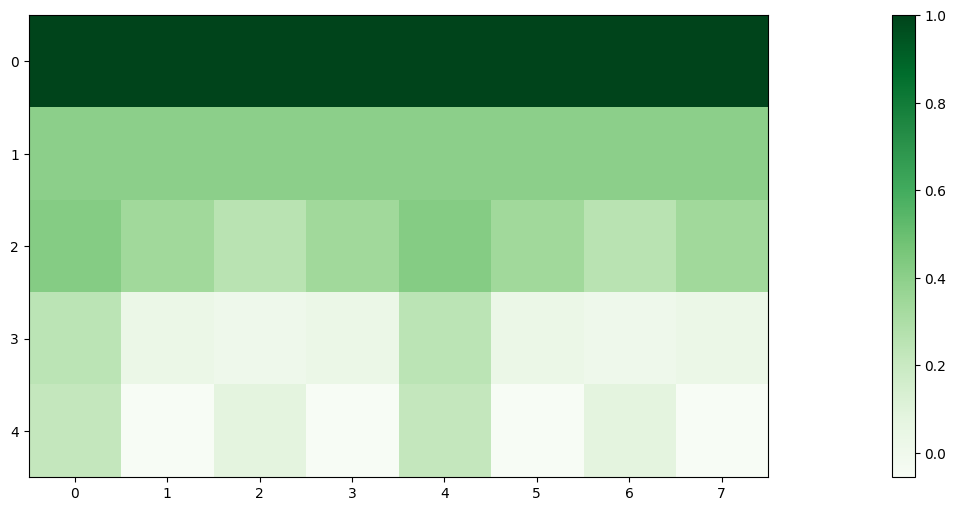

In [14]:
from matplotlib.colors import LogNorm
plt.imshow(matrix, cmap = 'Greens', interpolation ='nearest')
plt.colorbar()
plt.savefig('heat_map.pdf', format = 'pdf') 